#### Predicting Rossmann Store Sales

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

https://www.kaggle.com/omarelgabry/a-journey-through-rossmann-stores 

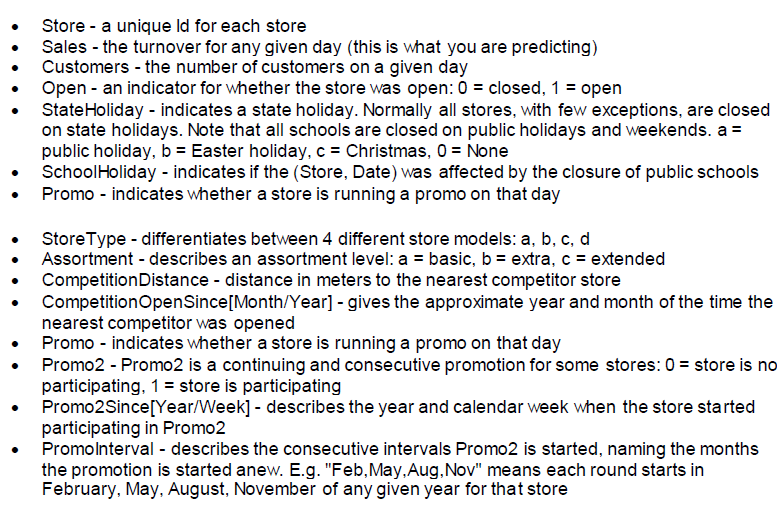

#### Import Libraries

In [1]:
%matplotlib inline

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

#### Using sklearn

In [2]:
# Get rossmann, store, & test csv files as a DataFrame

rossmann_df  = pd.read_csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\Store Sales Prediction\\Rossman Stores\\train.csv")
store_df     = pd.read_csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\Store Sales Prediction\\Rossman Stores\\store.csv")
test_df      = pd.read_csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\Store Sales Prediction\\Rossman Stores\\test.csv")

C:\Users\SESA475934\Anaconda3\envs\Python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Preview the data
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
rossmann_df.info()
print("----------------------------")
store_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 n

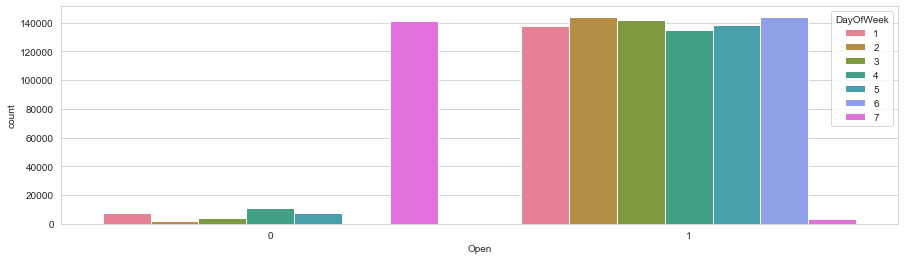

In [5]:
# Open/Closed stores on Days of the week

fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=rossmann_df,palette="husl", ax=axis1)

In [6]:
# Fill NaN values in test_df with Open=1 if DayOfWeek != 7

test_df["Open"][test_df["Open"] != test_df["Open"]] = (test_df["DayOfWeek"] != 7).astype(int)

C:\Users\SESA475934\Anaconda3\envs\Python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Drop Open column
# rossmann_df.drop("Open", axis=1, inplace=True)
# test_df.drop("Open", axis=1, inplace=True)

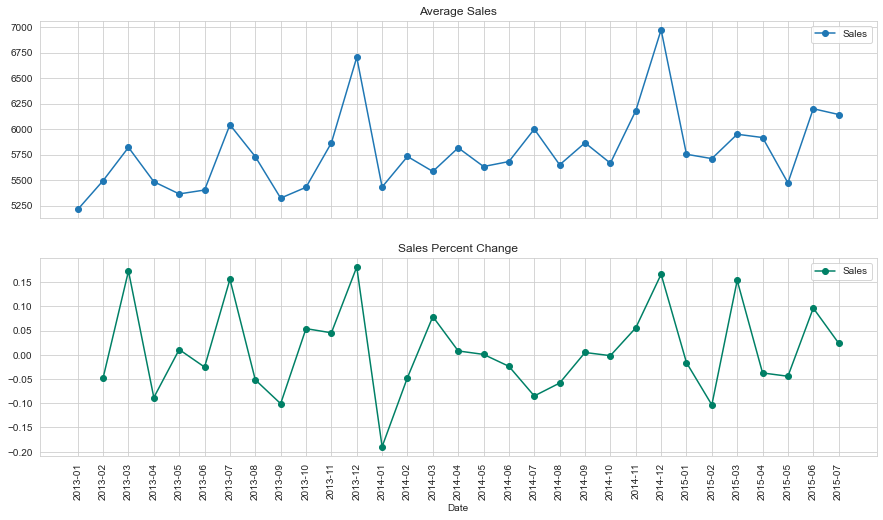

In [8]:
# Average Sales and % change in Sales

# Create Year and Month columns
rossmann_df['Year']  = rossmann_df['Date'].apply(lambda x: int(str(x)[:4]))
rossmann_df['Month'] = rossmann_df['Date'].apply(lambda x: int(str(x)[5:7]))

test_df['Year']  = test_df['Date'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization
rossmann_df['Date'] = rossmann_df['Date'].apply(lambda x: (str(x)[:7]))
test_df['Date']     = test_df['Date'].apply(lambda x: (str(x)[:7]))

# group by date and get average sales, and precent change
average_sales    = rossmann_df.groupby('Date')["Sales"].mean()
pct_change_sales = rossmann_df.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")
# ax2.set_xticks(range(len(pct_change_sales)))
# ax2.set_xticklabels(pct_change_sales.index.tolist(), rotation=90)

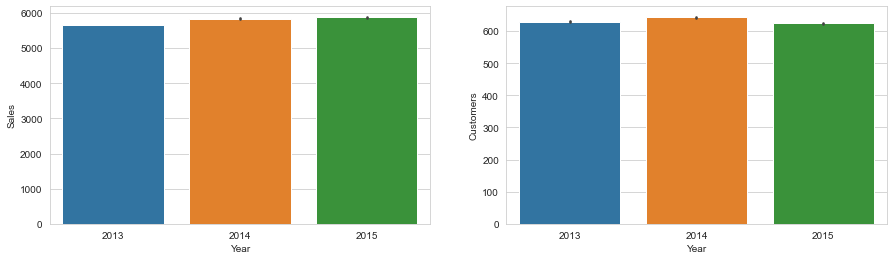

In [9]:
# Plot average sales & customers for every year
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='Sales', data=rossmann_df, ax=axis1)
sns.barplot(x='Year', y='Customers', data=rossmann_df, ax=axis2)

# Drop Date column
# rossmann_df.drop(['Date'], axis=1,inplace=True)
# test_df.drop(['Date'], axis=1,inplace=True)

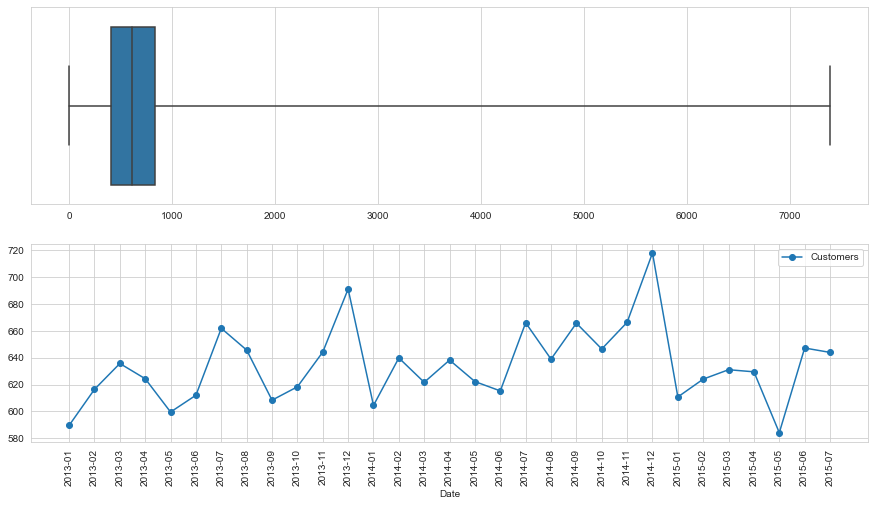

In [10]:
# Customers

fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,8))

# Plot max, min values, & 2nd, 3rd quartile
sns.boxplot([rossmann_df["Customers"]], whis=np.inf, ax=axis1)

# group by date and get average customers, and precent change
average_customers      = rossmann_df.groupby('Date')["Customers"].mean()
# pct_change_customers = rossmann_df.groupby('Date')["Customers"].sum().pct_change()

# Plot average customers over the time
# it should be correlated with the average sales over time
ax = average_customers.plot(legend=True,marker='o', ax=axis2)
ax.set_xticks(range(len(average_customers)))
xlabels = ax.set_xticklabels(average_customers.index.tolist(), rotation=90)

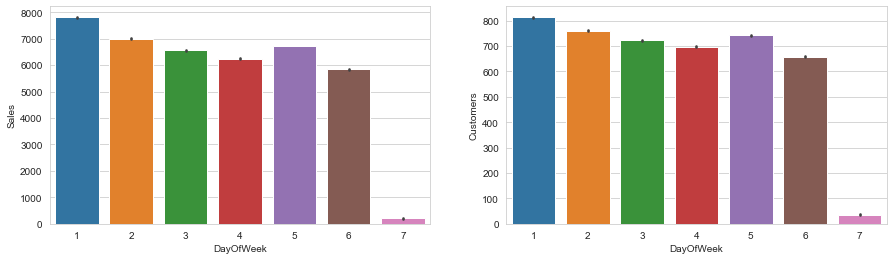

In [11]:
# DayOfWeek
# In both cases where the store is closed and opened

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=rossmann_df, order=[1,2,3,4,5,6,7], ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=rossmann_df, order=[1,2,3,4,5,6,7], ax=axis2)

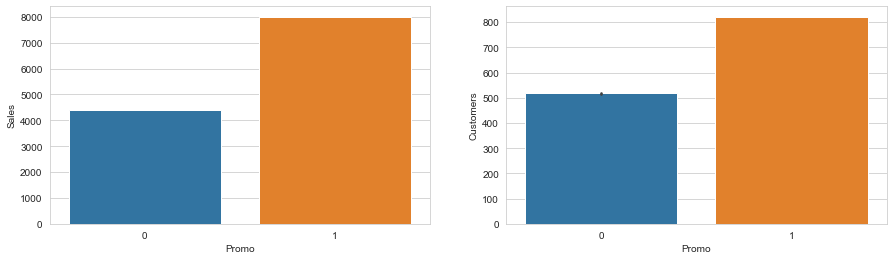

In [12]:
# Promo

# Plot average sales & customers with/without promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=rossmann_df, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=rossmann_df, ax=axis2)

C:\Users\SESA475934\Anaconda3\envs\Python36\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


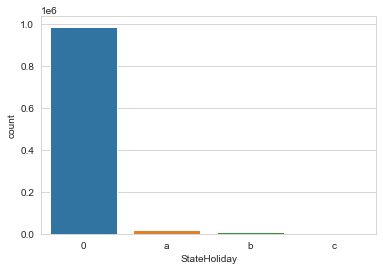

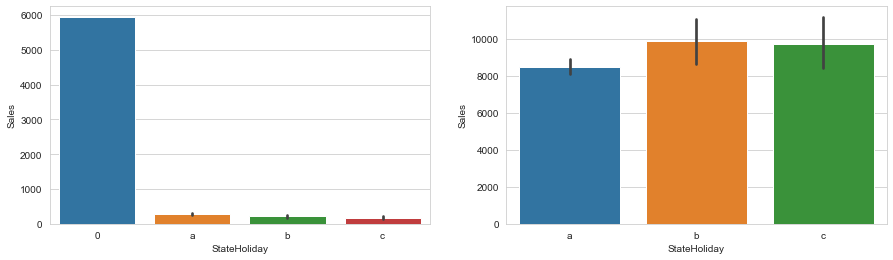

In [13]:
# StateHoliday

# StateHoliday column has values 0 & "0", So, we need to merge values with 0 to "0"
rossmann_df["StateHoliday"].loc[rossmann_df["StateHoliday"] == 0] = "0"
# test_df["StateHoliday"].loc[test_df["StateHoliday"] == 0] = "0"

# Plot
sns.countplot(x='StateHoliday', data=rossmann_df)

# Before
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=rossmann_df, ax=axis1)

mask = (rossmann_df["StateHoliday"] != "0") & (rossmann_df["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=rossmann_df[mask], ax=axis2)

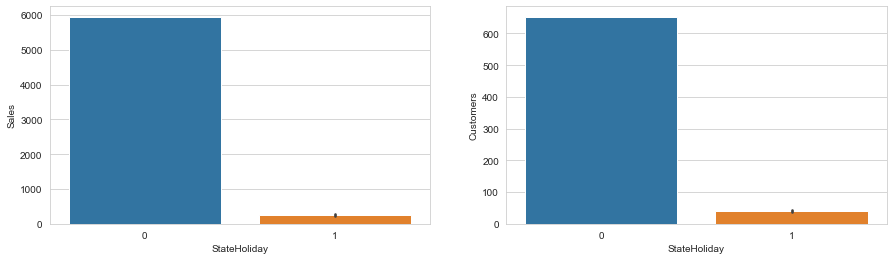

In [14]:
# .... continue with StateHoliday

# After
rossmann_df["StateHoliday"] = rossmann_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test_df["StateHoliday"]     = test_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=rossmann_df, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=rossmann_df, ax=axis2)

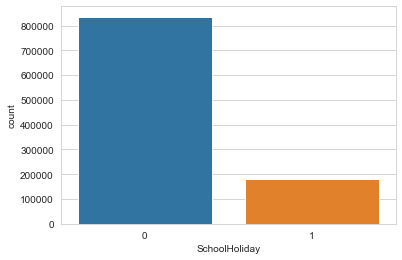

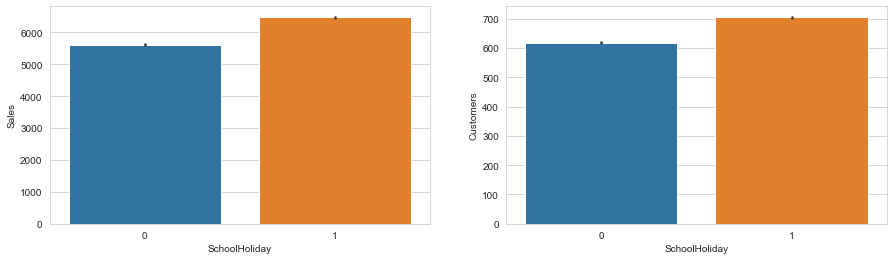

In [15]:
# SchoolHoliday

# Plot
sns.countplot(x='SchoolHoliday', data=rossmann_df)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=rossmann_df, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=rossmann_df, ax=axis2)

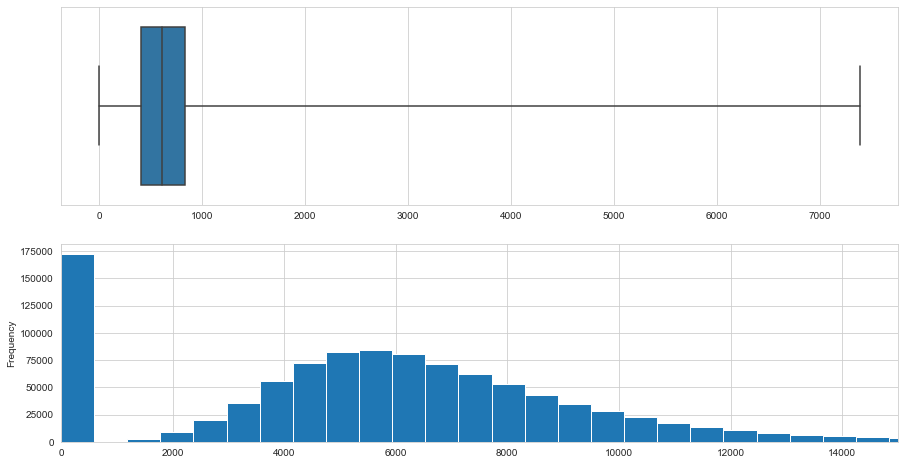

In [16]:
# Sales

fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,8))

# Plot max, min values, & 2nd, 3rd quartile
sns.boxplot([rossmann_df["Customers"]], whis=np.inf, ax=axis1)

# Plot sales values 
# Notice that values with 0 is mostly because the store was closed
rossmann_df["Sales"].plot(kind='hist',bins=70,xlim=(0,15000),ax=axis2)

In [17]:
# Using store_df

# Merge store_df with average store sales & customers
average_sales_customers = rossmann_df.groupby('Store')[["Sales", "Customers"]].mean()
sales_customers_df = DataFrame({'Store':average_sales_customers.index,
                      'Sales':average_sales_customers["Sales"], 'Customers': average_sales_customers["Customers"]}, 
                      columns=[ 'Sales', 'Customers'])
store_df = pd.merge(sales_customers_df, store_df, on='Store')

store_df.head()

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,8021.769639,1100.057325,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,3867.110403,444.360934,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


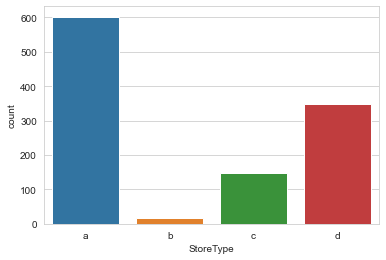

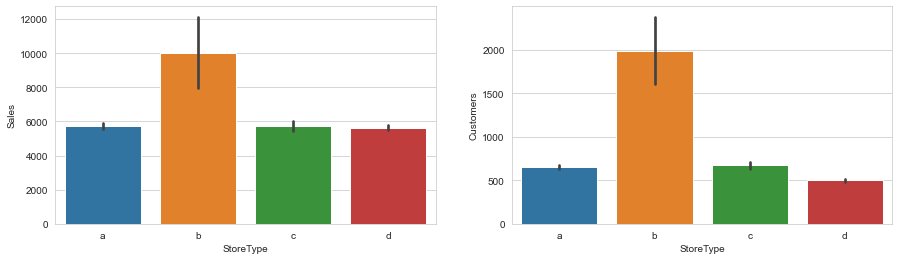

In [18]:
# StoreType 

# Plot StoreType, & StoreType Vs average sales and customers

sns.countplot(x='StoreType', data=store_df, order=['a','b','c', 'd'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StoreType', y='Sales', data=store_df, order=['a','b','c', 'd'],ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=store_df, order=['a','b','c', 'd'], ax=axis2)

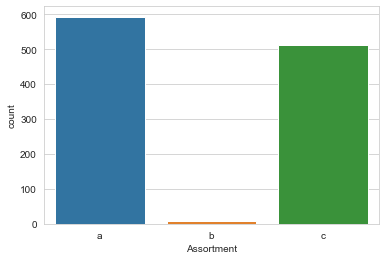

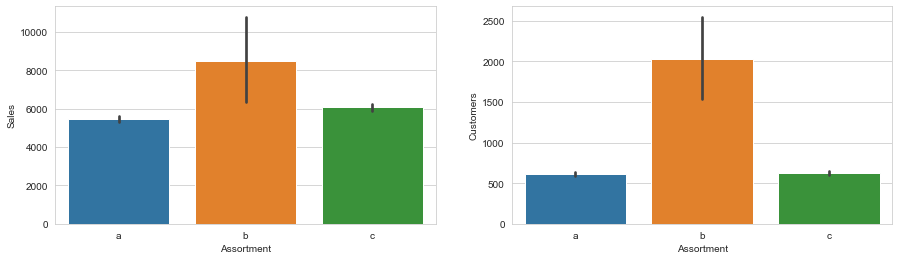

In [19]:
# Assortment 

# Plot Assortment, & Assortment Vs average sales and customers

sns.countplot(x='Assortment', data=store_df, order=['a','b','c'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Assortment', y='Sales', data=store_df, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=store_df, order=['a','b','c'], ax=axis2)

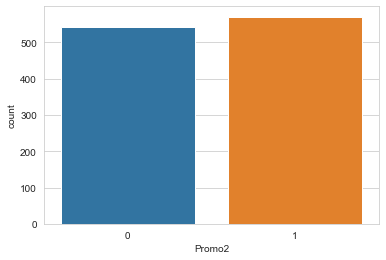

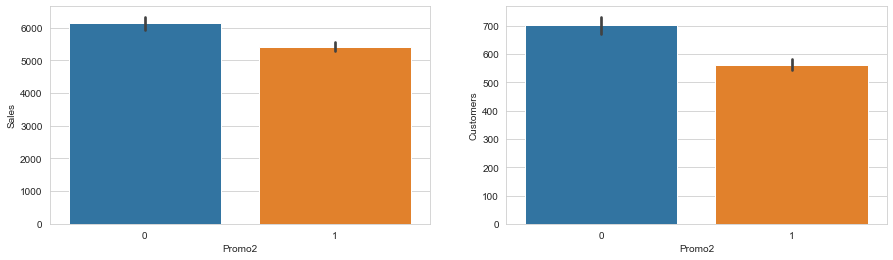

In [20]:
# Promo2

# Plot Promo2, & Promo2 Vs average sales and customers

sns.countplot(x='Promo2', data=store_df)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo2', y='Sales', data=store_df, ax=axis1)
sns.barplot(x='Promo2', y='Customers', data=store_df, ax=axis2)


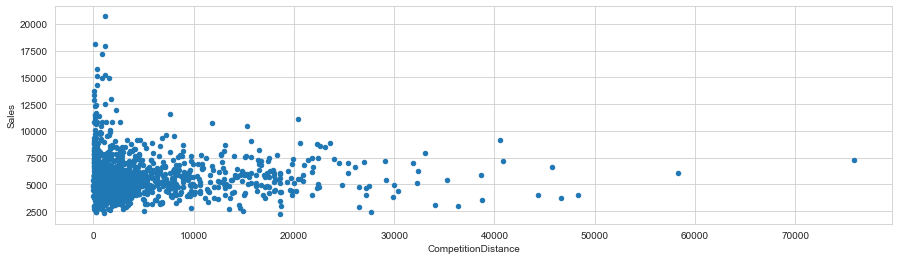

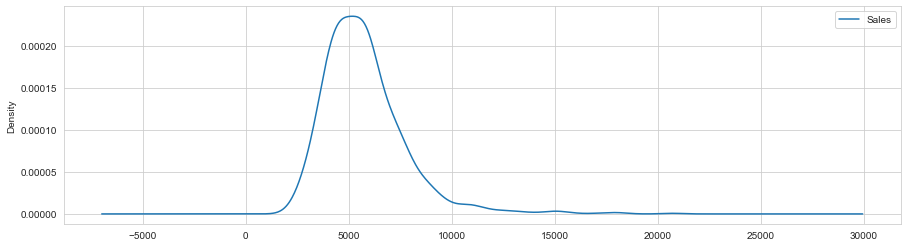

In [21]:
# CompetitionDistance

# fill NaN values
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median())

# Plot CompetitionDistance Vs Sales
store_df.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4))
store_df.plot(kind='kde',x='CompetitionDistance',y='Sales',figsize=(15,4))

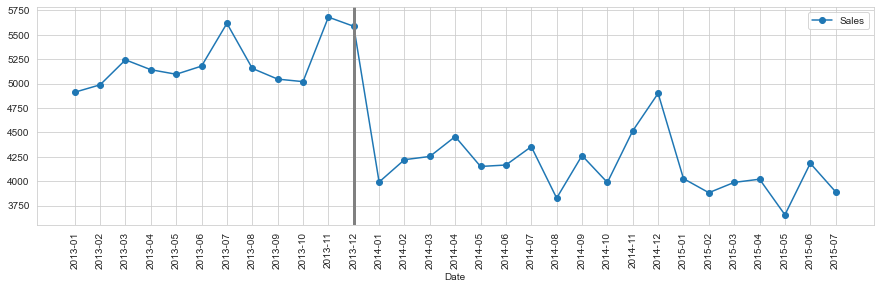

In [22]:
# What happened to the average sales of a store over time when competition started?
# Example: the average sales for store_id = 6 has dramatically decreased since the competition started

store_id = 6
store_data = rossmann_df[rossmann_df["Store"] == store_id]

average_store_sales = store_data.groupby('Date')["Sales"].mean()

# Get year, and month when Competition started
y = store_df["CompetitionOpenSinceYear"].loc[store_df["Store"]  == store_id].values[0]
m = store_df["CompetitionOpenSinceMonth"].loc[store_df["Store"] == store_id].values[0]

# Plot 
ax = average_store_sales.plot(legend=True,figsize=(15,4),marker='o')
ax.set_xticks(range(len(average_store_sales)))
ax.set_xticklabels(average_store_sales.index.tolist(), rotation=90)

# Since all data of store sales given in rossmann_df starts with year=2013 till 2015,
# So, we need to check if year>=2013 and y & m aren't NaN values.
if y >= 2013 and y == y and m == m:
    plt.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')

Text(50, 50, 'Store 6')

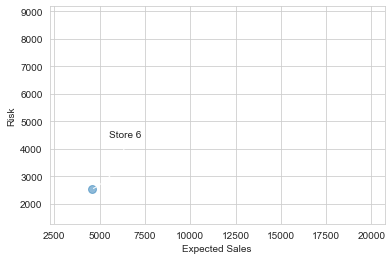

In [23]:
# Risk Analysis
# Analyze the risk of a store; Risk(std) Vs Expected(mean)

# .... countiue using store_data
store_average = store_data["Sales"].mean()
store_std     = store_data["Sales"].std()

# Plot
plt.scatter(store_average, store_std,alpha = 0.5,s =np.pi*20)

# Get min & max mean and std of store sales
# Remember that store_df["Sales"] has the average sales for a store
std_sales = rossmann_df.groupby('Store')["Sales"].std()

min_average = store_df["Sales"].min()
max_average = store_df["Sales"].max()
min_std     = std_sales.min()
max_std     = std_sales.max()

# Set the x and y limits of the plot
plt.ylim([min_std, max_std])
plt.xlim([min_average, max_average])

# Set the plot axis titles
plt.xlabel('Expected Sales')
plt.ylabel('Risk')

# Set label
label, x, y = "Store {}".format(store_id), store_average, store_std
plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))

In [24]:
# Correlation
# Visualize the Correlation between stores

store_piv       = pd.pivot_table(rossmann_df,values='Sales', index='Date', columns=['Store'],aggfunc='sum')
store_pct_chage = store_piv.pct_change().dropna()
store_piv.head()

Store,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
Date,,,,,,,,,,,,,,,,,,,,,
2013-01,128431.0,115171.0,165653.0,234713.0,109442.0,152265.0,188032.0,122293.0,127016.0,130042.0,...,115116.0,143763.0,143571.0,119190.0,106800.0,128626.0,304489.0,155879.0,456530.0,116482.0
2013-02,125271.0,111114.0,160167.0,230473.0,101126.0,139655.0,178830.0,119828.0,126826.0,122956.0,...,107923.0,140576.0,127544.0,115328.0,99489.0,122822.0,301544.0,147817.0,446745.0,123114.0
2013-03,145169.0,130525.0,189179.0,255514.0,116860.0,162550.0,213082.0,135408.0,143583.0,133609.0,...,124035.0,170060.0,148065.0,124393.0,116539.0,138298.0,312362.0,171412.0,516987.0,155033.0
2013-04,118009.0,116878.0,172188.0,226981.0,106141.0,154269.0,197381.0,127236.0,136194.0,131040.0,...,110478.0,154915.0,132135.0,118303.0,106745.0,131652.0,284870.0,148796.0,497336.0,126212.0
2013-05,118225.0,116379.0,170374.0,235284.0,110292.0,157972.0,210921.0,126886.0,136540.0,130642.0,...,111092.0,151585.0,131119.0,117329.0,105277.0,128784.0,284762.0,155649.0,503359.0,131329.0


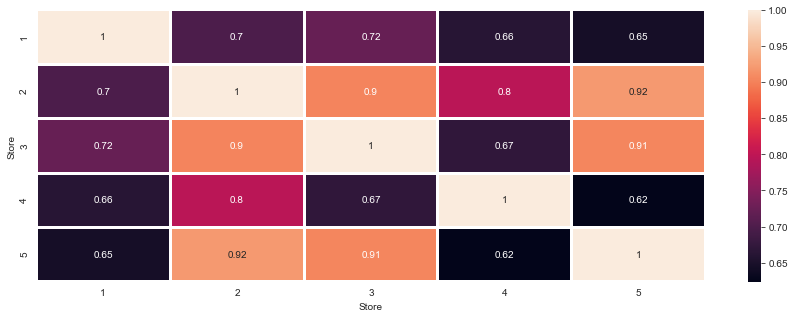

In [25]:
# .... continue Correlation

# Plot correlation between range of stores
start_store = 1
end_store   = 5

fig, (axis1) = plt.subplots(1,1,figsize=(15,5))

# using summation of sales values for each store 
sns.heatmap(store_piv[list(range(start_store, end_store+1))].corr(),annot=True,linewidths=2)

# using percent change for each store
# sns.heatmap(store_pct_chage[list(range(start_store, end_store+1))].corr(),annot=True,linewidths=2)

In [26]:
# Notice that test_df has only year=2015, and months 8 & 9

# drop Year and Month
rossmann_df.drop(["Year", "Month"], axis=1, inplace=True)
test_df.drop(["Year", "Month"], axis=1, inplace=True)

# Create dummy varibales for DayOfWeek
day_dummies_rossmann  = pd.get_dummies(rossmann_df['DayOfWeek'], prefix='Day')
day_dummies_rossmann.drop(['Day_7'], axis=1, inplace=True)

day_dummies_test  = pd.get_dummies(test_df['DayOfWeek'],prefix='Day')
day_dummies_test.drop(['Day_7'], axis=1, inplace=True)

rossmann_df = rossmann_df.join(day_dummies_rossmann)
test_df     = test_df.join(day_dummies_test)

rossmann_df.drop(['DayOfWeek'], axis=1,inplace=True)
test_df.drop(['DayOfWeek'], axis=1,inplace=True)

In [27]:
# Remove all rows(store,date) that were closed
rossmann_df = rossmann_df[rossmann_df["Open"] != 0]

# Drop unnecessary columns, these columns won't be useful in prediction
rossmann_df.drop(["Open","Customers", "Date"], axis=1, inplace=True)

In [28]:
# Save ids of closed stores, because we will assign their sales value to 0 later(see below)
closed_store_ids = test_df["Id"][test_df["Open"] == 0].values

# Remove all rows(store,date) that were closed
test_df = test_df[test_df["Open"] != 0]

# Drop unnecessary columns, these columns won't be useful in prediction
test_df.drop(['Open', 'Date'], axis=1,inplace=True)

In [29]:
# Loop through each store, 
# Train the model using the data of current store, and predict it's sales values.

rossmann_dic = dict(list(rossmann_df.groupby('Store')))
test_dic     = dict(list(test_df.groupby('Store')))
submission   = Series()
scores       = []

for i in test_dic:
    
    # current store
    store = rossmann_dic[i]
    
    # define training and testing sets
    X_train = store.drop(["Sales","Store"],axis=1)
    Y_train = store["Sales"]
    X_test  = test_dic[i].copy()
    
    store_ids = X_test["Id"]
    X_test.drop(["Id","Store"], axis=1,inplace=True)
    
    # Linear Regression
    lreg = LinearRegression()
    lreg.fit(X_train, Y_train)
    Y_pred = lreg.predict(X_test)
    scores.append(lreg.score(X_train, Y_train))

    # Xgboost
    #params = {"objective": "reg:linear",  "max_depth": 10}
    #T_train_xgb = xgb.DMatrix(X_train, Y_train)
    #X_test_xgb  = xgb.DMatrix(X_test)
    #gbm = xgb.train(params, T_train_xgb, 100)
    #Y_pred = gbm.predict(X_test_xgb)
    
    # append predicted values of current store to submission
    submission = submission.append(Series(Y_pred, index=store_ids))

# append rows(store,date) that were closed, and assign their sales value to 0
submission = submission.append(Series(0, index=closed_store_ids))

C:\Users\SESA475934\Anaconda3\envs\Python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [30]:
# Save to csv file

submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\Store Sales Prediction\\Rossman Stores\\rossmann.csv', index=False)

#### Using pyspark

In [191]:
### Initialize the spark

import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('rossman_store_sales').getOrCreate() 

In [192]:
import pyspark.ml as ml

In [33]:
spark.version

'2.4.6'

In [34]:
dir(spark)

['Builder',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_convert_from_pandas',
 '_createFromLocal',
 '_createFromRDD',
 '_create_from_pandas_with_arrow',
 '_create_shell_session',
 '_get_numpy_record_dtype',
 '_inferSchema',
 '_inferSchemaFromList',
 '_instantiatedSession',
 '_jsc',
 '_jsparkSession',
 '_jvm',
 '_jwrapped',
 '_repr_html_',
 '_sc',
 '_wrapped',
 'builder',
 'catalog',
 'conf',
 'createDataFrame',
 'newSession',
 'range',
 'read',
 'readStream',
 'sparkContext',
 'sql',
 'stop',
 'streams',
 'table',
 'udf',
 'version']

In [35]:
%pwd

'C:\\Users\\SESA475934\\PySpark Projects'

In [193]:
# Load the dataset
rossmann_df  = spark.read.csv('C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\Store Sales Prediction\\Rossman Stores\\train.csv',inferSchema=True,header=True)
store_df  = spark.read.csv('C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\Store Sales Prediction\\Rossman Stores\\store.csv',inferSchema=True,header=True)
test_df  = spark.read.csv('C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\Store Sales Prediction\\Rossman Stores\\test.csv',inferSchema=True,header=True)

In [194]:
rossmann_df.schema

StructType(List(StructField(Store,IntegerType,true),StructField(DayOfWeek,IntegerType,true),StructField(Date,TimestampType,true),StructField(Sales,IntegerType,true),StructField(Customers,IntegerType,true),StructField(Open,IntegerType,true),StructField(Promo,IntegerType,true),StructField(StateHoliday,StringType,true),StructField(SchoolHoliday,IntegerType,true)))

In [195]:
rossmann_df.count()

1017209

In [111]:
rossmann_df.show(5)

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|
|    2|        5|2015-07-31 00:00:00| 6064|      625|   1|    1|           0|            1|
|    3|        5|2015-07-31 00:00:00| 8314|      821|   1|    1|           0|            1|
|    4|        5|2015-07-31 00:00:00|13995|     1498|   1|    1|           0|            1|
|    5|        5|2015-07-31 00:00:00| 4822|      559|   1|    1|           0|            1|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
only showing top 5 rows



In [196]:
# Let's cache the dataset
rossmann_df.cache()
rossmann_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)



In [113]:
rossmann_df.describe().show()

+-------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+------------+-------------------+
|summary|            Store|        DayOfWeek|            Sales|         Customers|               Open|              Promo|StateHoliday|      SchoolHoliday|
+-------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+------------+-------------------+
|  count|          1017209|          1017209|          1017209|           1017209|            1017209|            1017209|     1017209|            1017209|
|   mean|558.4297268309659|3.998340557348588|5773.818972305593| 633.1459464082602| 0.8301066939045958| 0.3815145166824124|         0.0|0.17864666946517382|
| stddev|321.9086511434535| 1.99739096494053|3849.926175234754|464.41173388663157|0.37553922469319545|0.48575860487742045|         0.0|0.38305636818092614|
|    min|                1|                1|                0| 

In [197]:
#Keep a copy of the original dataframe for later use
rossmann_original_df = rossmann_df

In [198]:
#Columns that will be used as features and their types
continuous_features = ['Store', 'Customers'] 

categorical_features = ['DayOfWeek', 'Open',
                      'Promo', 'StateHoliday',
                      'SchoolHoliday']

In [199]:
#Encoding all categorical features
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

In [200]:
#Define a function to create categorical features
def create_category_vars( dataset, field_name ):
    idx_col = field_name + "Index"
    col_vec = field_name + "Vec"
    month_stringIndexer = StringIndexer( inputCol=field_name, outputCol=idx_col )
    month_model = month_stringIndexer.fit( dataset )
    month_indexed = month_model.transform( dataset )
    month_encoder = OneHotEncoder( dropLast=True,inputCol=idx_col, outputCol= col_vec )
    return month_encoder.transform( month_indexed )

In [201]:
#Encoding all categorical features
#from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

for col in categorical_features:
    rossmann_df = create_category_vars( rossmann_df, col )

rossmann_df.cache()

DataFrame[Store: int, DayOfWeek: int, Date: timestamp, Sales: int, Customers: int, Open: int, Promo: int, StateHoliday: string, SchoolHoliday: int, DayOfWeekIndex: double, DayOfWeekVec: vector, OpenIndex: double, OpenVec: vector, PromoIndex: double, PromoVec: vector, StateHolidayIndex: double, StateHolidayVec: vector, SchoolHolidayIndex: double, SchoolHolidayVec: vector]

In [202]:
rossmann_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)
 |-- DayOfWeekIndex: double (nullable = false)
 |-- DayOfWeekVec: vector (nullable = true)
 |-- OpenIndex: double (nullable = false)
 |-- OpenVec: vector (nullable = true)
 |-- PromoIndex: double (nullable = false)
 |-- PromoVec: vector (nullable = true)
 |-- StateHolidayIndex: double (nullable = false)
 |-- StateHolidayVec: vector (nullable = true)
 |-- SchoolHolidayIndex: double (nullable = false)
 |-- SchoolHolidayVec: vector (nullable = true)



In [203]:
print(rossmann_df.show(5))

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+--------------+-------------+---------+-------------+----------+---------+-----------------+---------------+------------------+----------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|DayOfWeekIndex| DayOfWeekVec|OpenIndex|      OpenVec|PromoIndex| PromoVec|StateHolidayIndex|StateHolidayVec|SchoolHolidayIndex|SchoolHolidayVec|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+--------------+-------------+---------+-------------+----------+---------+-----------------+---------------+------------------+----------------+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|           1.0|(6,[1],[1.0])|      0.0|(1,[0],[1.0])|       1.0|(1,[],[])|              0.0|  (3,[0],[1.0])|               1.0|       (1,[],[])|
|    2|        5|2015-07-31 00:00:00| 6064|      625|   

In [204]:
rossmann_df.describe()

DataFrame[summary: string, Store: string, DayOfWeek: string, Sales: string, Customers: string, Open: string, Promo: string, StateHoliday: string, SchoolHoliday: string, DayOfWeekIndex: string, OpenIndex: string, PromoIndex: string, StateHolidayIndex: string, SchoolHolidayIndex: string]

In [206]:
#Create vectors from all features column
featureCols = continuous_features + ['DayOfWeekVec',
                                   'OpenVec',
                                   'PromoVec',
                                   'StateHolidayVec',
                                   'SchoolHolidayVec']

In [207]:
rossmann_df.select('StateHolidayVec').show(5)


+---------------+
|StateHolidayVec|
+---------------+
|  (3,[0],[1.0])|
|  (3,[0],[1.0])|
|  (3,[0],[1.0])|
|  (3,[0],[1.0])|
|  (3,[0],[1.0])|
+---------------+
only showing top 5 rows



In [208]:
featureCols

['Store',
 'Customers',
 'DayOfWeekVec',
 'OpenVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec']

In [209]:
from pyspark.sql.functions import col, log

rossmann_df = rossmann_df.withColumn( 'log_sales', log('Sales') )

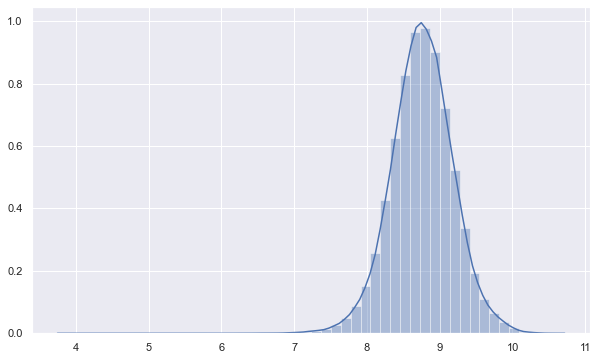

In [210]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.distplot(rossmann_df.select('log_sales').toPandas(), norm_hist=True)

#### Preparing for model building

    The dataframe need to have two columns: features and label
    The vector columns need to named as features
    The target variable need to be named as label
    Then the dataframe can be directly fed to a model to learn

In [211]:
assembler = VectorAssembler( inputCols = featureCols, outputCol = "features")

In [212]:
assembler.outputCol

Param(parent='VectorAssembler_c4688d2175e9', name='outputCol', doc='output column name.')

In [213]:
rossmann_train_df = assembler.transform( rossmann_df )

In [214]:
rossmann_train_df.show( 5 )

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+--------------+-------------+---------+-------------+----------+---------+-----------------+---------------+------------------+----------------+-----------------+--------------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|DayOfWeekIndex| DayOfWeekVec|OpenIndex|      OpenVec|PromoIndex| PromoVec|StateHolidayIndex|StateHolidayVec|SchoolHolidayIndex|SchoolHolidayVec|        log_sales|            features|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+--------------+-------------+---------+-------------+----------+---------+-----------------+---------------+------------------+----------------+-----------------+--------------------+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|           1.0|(6,[1],[1.0])|      0.0|(1,[0],[1.0])|       1.0|(1,[],[])|          

In [234]:
from pyspark.sql.functions import round

rossmann_train_df = rossmann_train_df.withColumn( "label", round('Sales', 4) )

In [235]:
rossmann_train_df.head(2)

[Row(Store=1, DayOfWeek=5, Date=datetime.datetime(2015, 7, 31, 0, 0), Sales=5263, Customers=555, Open=1, Promo=1, StateHoliday='0', SchoolHoliday=1, DayOfWeekIndex=1.0, DayOfWeekVec=SparseVector(6, {1: 1.0}), OpenIndex=0.0, OpenVec=SparseVector(1, {0: 1.0}), PromoIndex=1.0, PromoVec=SparseVector(1, {}), StateHolidayIndex=0.0, StateHolidayVec=SparseVector(3, {0: 1.0}), SchoolHolidayIndex=1.0, SchoolHolidayVec=SparseVector(1, {}), log_sales=8.56845648535378, features=SparseVector(14, {0: 1.0, 1: 555.0, 3: 1.0, 8: 1.0, 10: 1.0}), label=5263),
 Row(Store=2, DayOfWeek=5, Date=datetime.datetime(2015, 7, 31, 0, 0), Sales=6064, Customers=625, Open=1, Promo=1, StateHoliday='0', SchoolHoliday=1, DayOfWeekIndex=1.0, DayOfWeekVec=SparseVector(6, {1: 1.0}), OpenIndex=0.0, OpenVec=SparseVector(1, {0: 1.0}), PromoIndex=1.0, PromoVec=SparseVector(1, {}), StateHolidayIndex=0.0, StateHolidayVec=SparseVector(3, {0: 1.0}), SchoolHolidayIndex=1.0, SchoolHolidayVec=SparseVector(1, {}), log_sales=8.710124927

In [236]:
#Split the dataset
train_df, test_df = rossmann_train_df.randomSplit( [0.75, 0.25], seed = 42 )

In [237]:
#Build the Linear Regression Model
from pyspark.ml.regression import LinearRegression

In [238]:
linreg = LinearRegression(maxIter=500, regParam=0.0)

In [239]:
lm = linreg.fit( train_df )

In [240]:
lm.intercept

563.2757960257154

In [241]:
lm.coefficients

DenseVector([-0.151, 6.0469, 879.0923, 1034.1975, 931.3012, 1116.3459, 1354.9178, 1688.7695, 548.9736, -1410.9057, 1048.2585, -542.7545, -1138.3908, -141.706])

In [242]:
y_pred_train = lm.transform(train_df)

In [243]:
#Make predictions on test data and evaluate
y_pred_test = lm.transform(test_df)

In [244]:
y_pred_test.select( 'features',  'label', 'prediction', 'Sales' ).show(5)

+--------------------+-----+-------------------+-----+
|            features|label|         prediction|Sales|
+--------------------+-----+-------------------+-----+
|(14,[0,7,9,12],[1...|    0|-297.40218634315966|    0|
|(14,[0,1,7,8,10,1...| 5377|  7178.356310226498| 5377|
|(14,[0,1,7,8,9,10...| 3722|  5199.039488396669| 3722|
|(14,[0,1,7,8,10,1...| 5197|  6978.807730700633| 5197|
|(14,[0,1,7,8,9,10...| 4395|  5477.198114402418| 4395|
+--------------------+-----+-------------------+-----+
only showing top 5 rows



In [245]:
#Calculate the actual predicted price
from pyspark.sql.functions import exp

y_pred_test = y_pred_test.withColumn( "y_pred", exp( 'prediction' ) )

#y_pred_test = y_pred_test.withColumn( "y_pred", "prediction" )

In [246]:
#Calculate RMSE
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol="Sales",
                              predictionCol="y_pred",
                              metricName="rmse" )

In [250]:
lm_rmse = rmse_evaluator.evaluate( y_pred_test )
lm_rmse

inf

In [230]:
#Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="Sales",
                              predictionCol="y_pred",
                              metricName="r2" )

In [233]:
lm_r2 = r2_evaluator.evaluate( y_pred_test )
lm_r2

-inf